# Training a Raspberry Pi to Detect Traffic Signs and People in Real Time

This is tutorial is based on Chengwei's excellent Tutorial and Colab Notebook on ["How to train an object detection model easy for free"](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/).   My twist on his tutorial is that I need to run my model on a Raspberry Pi with live video feed.  As the Raspberry Pi is fairly limited on CPU power and can only run object detection at 1-2 FPS (frames/sec), I have purchased the newly release $75 Google's [EdgeTPU USB Accelarator](https://coral.withgoogle.c<om/products/accelerator), which can detect objects at 12 FPS, which is sufficient for real time work.  After doing the transfer learning from one of the object detection models using our own images, last few steps of the colab deals with how to convert a trained model to a model file that can be consumed by an Edge TPU, namely, the final `mymodel_quantized_edgetpu.tflite` file.  


![](https://cdn-images-1.medium.com/max/1000/1*_jABdMfUVcyPdi5b3zlfVg.jpeg)



#Get the right version of Tensorflow

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


# Section 1: Mount Google drive
Mount my Google Drive and save modeling output files (`.ckpt`)  there, so that it won't be wiped out when colab Virtual Machine restarts.  It has an idle timeout of 90 min, and maximum daily usage of 12 hours.

Google will ask for an authenticate code when you run the following code, just follow the link in the output and allow access.   You can put the `model_dir` anywhere in your google drive.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
model_dir = '/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training'
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
!ls -ltra '{model_dir}'/..

Mounted at /content/gdrive
total 4
drwx------ 2 root root 4096 Mar 18 14:01 Training


# Section 2: Set up Training Environment

## Installation and Dependencies

We need to install the following packages on which Tensorflow object detection APIs depend on

In [4]:
!sudo apt-get install protobuf-compiler  python-tk

!pip install tensorflow-object-detection-api

!pip install matplotlib 

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install pillow

!pip install lxml

!pip install tf_slim

!pip install lvis

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
     |████████████████████████████████| 358kB 5.2MB/s 


Now we need to download the Tensorflow model repository which contains all the libraries and other codes necessary for the training. We do that using the command:

In [5]:
 %cd /content
 !git clone --quiet https://github.com/tensorflow/models.git 

/content


Clone the chef_oeuvre repository to get the necessary data and code.

In [6]:
import os

repo_url = 'https://github.com/YohanCaillau/projet_chef_oeuvre'

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

print('Pull it so that we have the latest code/data')
!git pull

/content
Cloning into 'projet_chef_oeuvre'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 1322 (delta 24), reused 224 (delta 20), pack-reused 1074
Receiving objects: 100% (1322/1322), 224.49 MiB | 36.13 MiB/s, done.
Resolving deltas: 100% (131/131), done.
Checking out files: 100% (1128/1128), done.
/content/projet_chef_oeuvre
Pull it so that we have the latest code/data
Already up to date.


##Protobuf Compilation

Now, move to the research directory (cd models/research/) and compile the protobuf libraries as follows:

In [7]:
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/models/research


##Add Libraries to PYTHONPATH

When running locally, the models/research/ and slim directories should be appended to PYTHONPATH. This can be done by running the following from models/research/:

In [8]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

os.environ['PYTHONPATH'] += ":/content/models"

import sys
sys.path.append("/content/models")

##Completing setup

From directory model/research, run the following commands

In [9]:
%cd /content/models/research/slim

!python setup.py build

!python setup.py install

/content/models/research/slim
running build
running build_py
creating build
creating build/lib
creating build/lib/preprocessing
copying preprocessing/__init__.py -> build/lib/preprocessing
copying preprocessing/cifarnet_preprocessing.py -> build/lib/preprocessing
copying preprocessing/preprocessing_factory.py -> build/lib/preprocessing
copying preprocessing/lenet_preprocessing.py -> build/lib/preprocessing
copying preprocessing/inception_preprocessing.py -> build/lib/preprocessing
copying preprocessing/vgg_preprocessing.py -> build/lib/preprocessing
creating build/lib/deployment
copying deployment/__init__.py -> build/lib/deployment
copying deployment/model_deploy_test.py -> build/lib/deployment
copying deployment/model_deploy.py -> build/lib/deployment
creating build/lib/datasets
copying datasets/cifar10.py -> build/lib/datasets
copying datasets/process_bounding_boxes.py -> build/lib/datasets
copying datasets/visualwakewords.py -> build/lib/datasets
copying datasets/preprocess_imagene

##Testing the Installation

Now you can test if your Tensorflow setup for object detection was successful by running the following command from model/research directory:

In [10]:
%cd /content/models/research

!python object_detection/builders/model_builder_tf1_test.py

/content/models/research
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_faster

## Prepare `tfrecord` files

After labeling all the images and saving their corresponding XML files, we need now to generate a tfrecord file for both the train and test images. To generate the tfrecord files, we need first to create the .csv files from the XML files created during labeling.

To do this, we need two scripts (xml_to_csv.py and generate_tfrecord.py) available at Dat Tran’s raccoon detector. Download this scripts and move them to models/research/object_detection directory, where your images directory is found.

Use the following scripts to generate the `tfrecord` files.


In [11]:
%cd /content/projet_chef_oeuvre/models/object_detection/

!python code/xml_to_csv.py

!python code/generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --image_dir=data/images/train --output_path=data/annotations/train.record

!python code/generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --image_dir=data/images/test --output_path=data/annotations/test.record

/content/projet_chef_oeuvre/models/object_detection
Successfully converted xml to csv.
Successfully converted xml to csv.


W0325 16:53:19.920989 140115897644928 module_wrapper.py:139] From code/generate_tfrecord.py:96: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0325 16:53:19.939526 140115897644928 module_wrapper.py:139] From code/generate_tfrecord.py:55: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/projet_chef_oeuvre/models/object_detection/data/annotations/train.record


W0325 16:53:22.008098 140323404662656 module_wrapper.py:139] From code/generate_tfrecord.py:96: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0325 16:53:22.013551 140323404662656 module_wrapper.py:139] From code/generate_tfrecord.py:55: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the T

# Section 3: Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [12]:
# Number of training steps.
num_steps = 2000

# Number of evaluation steps.
num_eval_steps = 50


# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Download base model

In [13]:
%cd /content/models/research/object_detection

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)



/content/models/research/object_detection


In [14]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 204M
drwx------  2 303230 5000 4.0K Jan  4  2019 .
drwxr-xr-x 23 root   root 4.0K Mar 25 16:53 ..
-rw-------  1 303230 5000  93M Jan  4  2019 model.ckpt.data-00000-of-00001
-rw-------  1 303230 5000  68K Jan  4  2019 model.ckpt.index
-rw-------  1 303230 5000  20M Jan  4  2019 model.ckpt.meta
-rw-------  1 303230 5000 4.3K Jan  4  2019 pipeline.config
-rw-------  1 303230 5000  24M Jan  4  2019 tflite_graph.pb
-rw-------  1 303230 5000  68M Jan  4  2019 tflite_graph.pbtxt


In [15]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

# Section 4: Transfer Learning Training

## Create training config file and label map

Since, we have chosen to train from ssd_mobilenet_v2_quantized_coco model, we will use as config file ssd_mobilenet_v2_quantized_300x300_coco.config which can be found at /projet_chef_oeuvre/models/object_detection/configs that we have updated to fit our model

Check the label_map.pbtxt file containing the labels of our images

In [16]:
%cd /content/projet_chef_oeuvre/models/object_detection/data/annotations/

!cat label_map.pbtxt

/content/projet_chef_oeuvre/models/object_detection/data/annotations
item {
    id: 1
    name: '30 speed sign'
}

item {
    id: 2
    name: '50 speed sign'
}

item {
    id: 3
    name: 'green light'
}

item {
    id: 4
    name: 'person'
}

item {
    id: 5
    name: 'red light'
}

item {
    id: 6
    name: 'stop sign'
}

Now its time to train the model. To train our model we will copy the train.py file from object_detection/legacy folder to the object_detection folder. 

Run command below:

In [17]:
%cd /content/models/research/object_detection

# Number of training steps.
num_steps = 2000

# Number of evaluation steps.
num_eval_steps = 50
 
!python train.py \
    --pipeline_config_path=/content/projet_chef_oeuvre/models/object_detection/configs/ssd_mobilenet_v2_quantized_300x300_coco.config \
    --train_dir='{model_dir}'  \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

/content/models/research/object_detection
Instructions for updating:
Use object_detection/model_main.py.
W0325 16:54:50.221145 140414485309312 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/absl/app.py:251: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.
Instructions for updating:
Please switch to tf.train.create_global_step
W0325 16:54:50.488497 140414485309312 deprecation.py:323] From /content/models/research/object_detection/legacy/trainer.py:265: create_global_step (from tf_slim.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.create_global_step
INFO:tensorflow:Reading unweighted datasets: ['/content/projet_chef_oeuvre/models/object_detection/data/annotations/train*.record']
I0325 16:54:50.503970 140414485309312 dataset_builder.py:163] Reading unweighted datasets: ['/content/projet_chef_oeuvre/models/ob

In [18]:
!ls -ltra '{model_dir}'

total 758089
-rw------- 1 root root 119488618 Mar 20 00:51 events.out.tfevents.1616201489.a4ec70dbf05d
-rw------- 1 root root   5987361 Mar 20 06:11 events.out.tfevents.1616220669.a4ec70dbf05d
-rw------- 1 root root  35128166 Mar 25 15:28 events.out.tfevents.1616686135.aaffdf1afe5e
-rw------- 1 root root     68804 Mar 25 15:53 model.ckpt-1328.index
-rw------- 1 root root  75237296 Mar 25 15:53 model.ckpt-1328.data-00000-of-00001
-rw------- 1 root root  17499921 Mar 25 15:53 model.ckpt-1328.meta
-rw------- 1 root root     68804 Mar 25 16:03 model.ckpt-1706.index
-rw------- 1 root root  75237296 Mar 25 16:03 model.ckpt-1706.data-00000-of-00001
-rw------- 1 root root  17499921 Mar 25 16:03 model.ckpt-1706.meta
-rw------- 1 root root  40446603 Mar 25 16:11 events.out.tfevents.1616686997.aaffdf1afe5e
-rw------- 1 root root   5986345 Mar 25 16:14 events.out.tfevents.1616688885.aaffdf1afe5e
-rw------- 1 root root  33535937 Mar 25 16:35 events.out.tfevents.1616690139.aaffdf1afe5e
-rw------- 1 

In [19]:
import os
import re
import numpy as np

output_directory = '%s/fine_tuned_model' % model_dir
os.makedirs(output_directory, exist_ok=True)

## Training Evaluation

Now, you can evaluate your model by using the eval.py file from object_detection/legacy folder that you move to object_detection. 

Run the following command to start the training evaluation.

In [21]:
%cd /content/models/research/object_detection

#Start the evaluation
!python eval.py \
  --pipeline_config_path=/content/projet_chef_oeuvre/models/object_detection/configs/ssd_mobilenet_v2_quantized_300x300_coco.config \
  --logtostderr \
  --checkpoint_dir='{model_dir}' \
  --eval_dir='{model_dir}' 

/content/models/research/object_detection
Instructions for updating:
Use object_detection/model_main.py.
W0325 16:36:27.574096 140538492192640 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/absl/app.py:251: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.
INFO:tensorflow:Reading unweighted datasets: ['/content/projet_chef_oeuvre/models/object_detection/data/annotations/test*.record']
I0325 16:36:27.597519 140538492192640 dataset_builder.py:163] Reading unweighted datasets: ['/content/projet_chef_oeuvre/models/object_detection/data/annotations/test*.record']
INFO:tensorflow:Reading record datasets for input file: ['/content/projet_chef_oeuvre/models/object_detection/data/annotations/test*.record']
I0325 16:36:27.598586 140538492192640 dataset_builder.py:80] Reading record datasets for input file: ['/content/projet_chef_oeuvre/models/object_detection/data/annotations/test*.record']


## TensorBoard

Setup ngrok and run TensorBoard on Colab
Ngrok executable can be directly downloaded to your Colab notebook, run those two lines of code.

In [20]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2021-03-25 16:57:17--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.3.7, 50.19.119.19, 54.236.206.131, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.3.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  34.2MB/s    in 0.4s    

2021-03-25 16:57:18 (34.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


After this, the executable file ngrok will be extracted to the current directory.

Next, let's fire up the TensorBoard in the background like this:

In [21]:
%cd /content/models/research/object_detection

LOG_DIR = '{model_dir}'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

/content/models/research/object_detection


It is assuming the TensorBoard log path is "model_dir", where we are going to tell Keras to log files.

Then, we can run ngrok to tunnel TensorBoard port 6006 to the outside world. This command also runs in the background.

In [22]:
get_ipython().system_raw('./ngrok http 6006 &')

One last step, we get the public URL where we can access the colab TensorBoard web page. 

This will output a URL you can click on, but wait! We haven't trained our model, so you not get any information from TensorBoard yet.

In [24]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://ef8027a92ad9.ngrok.io


# Section 5: Save and Convert Model Output

Now that we have successfully trained our model, we need to generate the inference graph. The inference graph is the file used by applications who want to run our model. 

To do that, we need to move to the training folder and check the save summary file with the highest step number. The summary files are usually named as model.ckpt-XXXXwhere XXXX is the step number. When we got it, we run the following code from the object_detection folder to generate the inference graph

In [25]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/model.ckpt-2002


Now that we have successfully trained our model, we need to generate the inference graph. The inference graph is the file used by applications who want to run our model. To do that, we need to move to the training folder and check the save summary file with the highest step number. The summary files are usually named as model.ckpt-XXXXwhere XXXX is the step number. 

In [26]:
%cd /content/models/research/object_detection

!python export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path /content/projet_chef_oeuvre/models/object_detection/configs/ssd_mobilenet_v2_quantized_300x300_coco.config \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

/content/models/research/object_detection
Instructions for updating:
Please use `layer.__call__` method instead.
W0325 16:59:20.044929 140338521839488 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0325 16:59:22.211760 140338521839488 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0325 16:59:22.249794 140338521839488 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0325 16:59:22.285225 140338521839488 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INF

This create an inference graph file with name frozen_inference_graph.pb in the inference_graph folder. You can use this file to run our trained model in your various applications

## Create Frozen graph

We will then create a TensorFlow frozen graph with compatible ops that can be used with TensorFlow lite. This is done by running the command below:

In [27]:
%cd /content/models/research/object_detection

!python export_tflite_ssd_graph.py \
    --pipeline_config_path=/content/projet_chef_oeuvre/models/object_detection/configs/ssd_mobilenet_v2_quantized_300x300_coco.config \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

/content/models/research/object_detection
Instructions for updating:
Please use `layer.__call__` method instead.
W0325 16:59:53.921886 140231434778496 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0325 16:59:56.064210 140231434778496 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0325 16:59:56.093986 140231434778496 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0325 16:59:56.122114 140231434778496 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INF

A directory named tflite is created containing two files:tflite_graph.pb & tflite_graph.pbtxt. Theadd_postprocessing flag enables the model to take advantage of a custom optimized detection post-processing operation which can be seen as a replacement for tf.image.non_max_suppression

Now we will convert the frozen graph(tflite_graph.pb) created above to the to the TensorFlow Lite flatbuffer format (detect.tflite). We do this with the command below

In [28]:
%cd /content/models/research/object_detection

!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
--graph_def_file='{output_directory}/tflite_graph.pb' \
--output_file='{output_directory}/road_signs_detection_quantized.tflite' \
--output_format=TFLITE \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=QUANTIZED_UINT8 \
--mean_values=128 \
--std_dev_values=127 \
--change_concat_input_ranges=false \
--allow_custom_ops

/content/models/research/object_detection
CONVERTING frozen graph to quantized TF Lite file...
2021-03-25 17:00:23.010497: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-03-25 17:00:23.028850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-25 17:00:23.029508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P4 major: 6 minor: 1 memoryClockRate(GHz): 1.1135
pciBusID: 0000:00:04.0
2021-03-25 17:00:23.029774: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-25 17:00:23.031315: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-25 17:00:23.033218: I tensorflow/stream_exe

In [29]:
!echo "CONVERTING frozen graph to unquantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_detection_float.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops 

CONVERTING frozen graph to unquantized TF Lite file...
2021-03-25 17:00:50.700585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-03-25 17:00:50.718156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-25 17:00:50.718799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P4 major: 6 minor: 1 memoryClockRate(GHz): 1.1135
pciBusID: 0000:00:04.0
2021-03-25 17:00:50.719063: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-25 17:00:50.720576: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-25 17:00:50.722207: I tensorflow/stream_executor/platform/default/dso_loader.cc:44]

In [30]:
print(output_directory)
!ls -ltra '{output_directory}'
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")  # this is tflite graph

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model
total 134955
-rw------- 1 root root  2232275 Mar 25 16:59 model.ckpt.meta
-rw------- 1 root root    23543 Mar 25 16:59 model.ckpt.index
-rw------- 1 root root 18922628 Mar 25 16:59 model.ckpt.data-00000-of-00001
-rw------- 1 root root       77 Mar 25 16:59 checkpoint
-rw------- 1 root root 19822860 Mar 25 16:59 frozen_inference_graph.pb
drwx------ 3 root root     4096 Mar 25 16:59 saved_model
-rw------- 1 root root     4227 Mar 25 16:59 pipeline.config
-rw------- 1 root root 54187608 Mar 25 17:00 tflite_graph.pbtxt
-rw------- 1 root root 19408134 Mar 25 17:00 tflite_graph.pb
-rw------- 1 root root  4793304 Mar 25 17:00 road_signs_detection_quantized.tflite
-rw------- 1 root root 18792516 Mar 25 17:00 road_signs_detection_float.tflite


## Run inference test

Test with images in repository `object_detection/data/images/test` directory.

In [31]:
import os
import glob

label_map_pbtxt_fname = '/content/projet_chef_oeuvre/models/object_detection/data/annotations/label_map.pbtxt'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname
print(PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join("/content/projet_chef_oeuvre/models/object_detection/data/images/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.JPG"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content/gdrive/My Drive/Colab Notebooks/TransferLearning/Training/fine_tuned_model/frozen_inference_graph.pb
['/content/projet_chef_oeuvre/models/object_detection/data/images/test/DSC_0013_1615652001817.JPG', '/content/projet_chef_oeuvre/models/object_detection/data/images/test/DSC_0007_1615651232219.JPG', '/content/projet_chef_oeuvre/models/object_detection/data/images/test/DSC_0030_1615651982129.JPG']


In [32]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [36]:
num_classes = get_num_classes(label_map_pbtxt_fname)

In [37]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


/content/models/research/object_detection


Running inferences on ['/content/projet_chef_oeuvre/models/object_detection/data/images/test/DSC_0013_1615652001817.JPG', '/content/projet_chef_oeuvre/models/object_detection/data/images/test/DSC_0007_1615651232219.JPG', '/content/projet_chef_oeuvre/models/object_detection/data/images/test/DSC_0030_1615651982129.JPG']


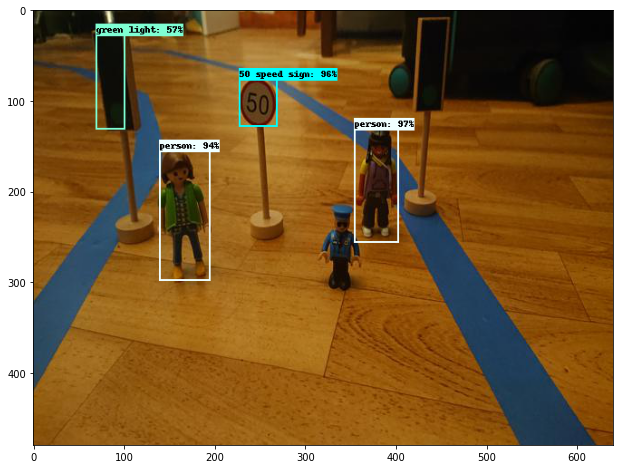

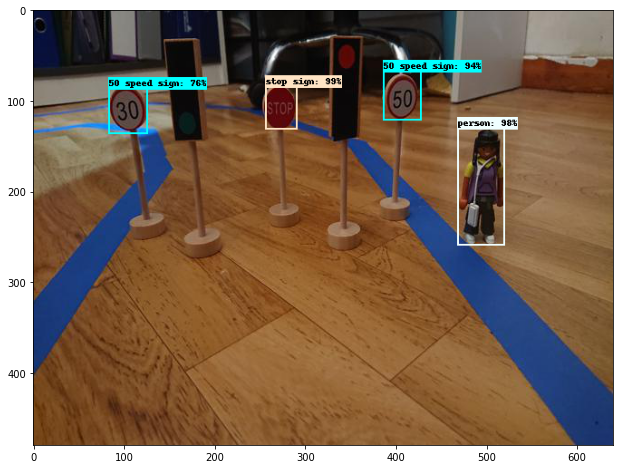

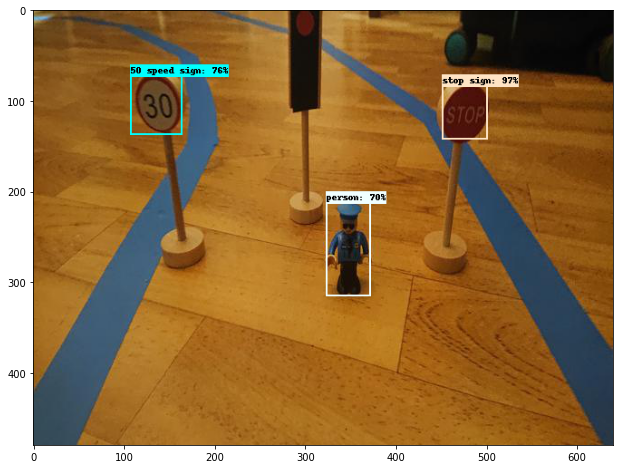

In [38]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## Convert to Edge TPU's tflite Format  
The only known way, at time of writing (April 2019), is to download the below quantized tflite file from above, and use [Google's web compiler](https://coral.withgoogle.com/web-compiler/) to convert to Edge TPU's tflite format.   Unfortunately, this step has to be done by hand, and NOT via a script.  

Here are the requirements of Edge TPU web compiler.  If you have followed the above steps closely, you have met these requirements.

- Tensor parameters are quantized (8-bit fixed-point numbers). You must use quantization-aware training (post-training quantization is not supported).   (this is why we are using `ssd_mobilenet_v2_quantized` base model and not the  `ssd_mobilenet_v2` base model   
- Tensor sizes are constant at compile-time (no dynamic sizes).
- Model parameters (such as bias tensors) are constant at compile-time.
- Tensors are either 1-, 2-, or 3-dimensional. If a tensor has more than 3 dimensions, then only the 3 innermost dimensions may have a size greater than 1.
- The model uses only the operations supported by the Edge TPU 

In [39]:
# download this file from google drive.
!ls -lt '/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model/road_signs_quantized.tflite'

-rw------- 1 root root 4793408 Mar 19 12:02 '/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model/road_signs_quantized.tflite'


In [40]:
# download this file from google drive.
!ls -lt '/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model/road_signs_quantized_edgetpu.tflite'

ls: cannot access '/content/gdrive/My Drive/Colab Notebooks/TransfertLearning/Training/fine_tuned_model/road_signs_quantized_edgetpu.tflite': No such file or directory


Wait for about 1-2 minutes for compilation to finish. And we can download the model file as road_signs_quantized_edgetpu.tflite. This is the file you need to copy to raspberry pi with TPU to run object detection.

We are all done with colab notebook training, now time to switch back to raspberry pi, and run ~/DeepPiCar/models/object_detection/code/object_detection_usb.py. You should see a video feed where road sign and persons are boxed with confidence level around them.

```bash
# make sure the the road_signs_quantized_edgetpu.tflite is in the right directory in your pi
pi@raspberrypi:~/DeepPiCar/models/object_detection/data/model_result $ ls -ltr
total 10040
-rw-r--r-- 1 pi pi      97 Apr 15 01:01 road_sign_labels.txt
-rw-r--r-- 1 pi pi 4793504 Apr 16 15:49 road_signs_quantized.tflite
-rw-r--r-- 1 pi pi 5478080 Apr 16 15:49 road_signs_quantized_edgetpu.tflite

pi@raspberrypi:~/DeepPiCar/models/object_detection $ python3 code/object_detection_usb.py

------
2019-04-16 16:22:28.489224: 13.49 FPS, 74.12ms total, 70.84ms in tf 
Green Traffic Light, 80% [[240.61578751 131.68985367]
 [287.21975327 195.79172134]] 60.42ms
Stop Sign, 44% [[  0.         305.1651001 ]
 [180.84949493 409.32563782]] 60.42ms

------
2019-04-16 16:22:28.618309: 14.83 FPS, 67.44ms total, 60.42ms in tf 
Person, 89% [[505.6583786  279.52325821]
 [530.85933685 360.0169754 ]] 62.54ms
Green Traffic Light, 72% [[237.96649933 130.58757782]
 [283.52127075 203.24180603]] 62.54ms
Red Traffic Light, 62% [[283.23583603 169.27398682]
 [330.91316223 269.20692444]] 62.54ms
Stop Sign, 56% [[ 51.01628304 165.80377579]
 [101.48646355 227.05183029]] 62.54ms
Person, 44% [[396.8661499  298.65327835]
 [468.4034729  422.04421997]] 62.54ms
------

```

https://teyou21.medium.com/setup-tensorflow-for-object-detection-on-ubuntu-16-04-e2485b52e32a

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

https://www.tensorflow.org/install

https://stackoverflow.com/questions/49836676/error-after-upgrading-pip-cannot-import-name-main

https://askubuntu.com/questions/320996/how-to-make-python-program-command-execute-python-3

https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

https://towardsdatascience.com/creating-your-own-object-detector-ad69dda69c85

https://neptune.ai/blog/how-to-train-your-own-object-detector-using-tensorflow-object-detection-api

https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/